In [1]:
import os

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import matplotlib.pyplot as plt

from dataset import build_dataset
from solver import Solver
from utils import seed_torch, CheckPointer
from config import cfg
from network import build_model, build_loss

In [2]:
cfg_file = 'config/nef_net.yml'

cfg.merge_from_file(cfg_file)
cfg.desc = cfg_file.split('/')[-1].replace('.yml', '')
cfg.output_dir = 'output/weight/'
cfg.output_dir = os.path.join(cfg.output_dir, cfg.desc)
cfg.latent_save_dir = 'output/result_save'
cfg.latent_save_dir = os.path.join(cfg.latent_save_dir, cfg.desc)

In [3]:
# All 84 angle(7 theta * 12 pthi) in Spherical coordinate system
theta = np.arange(0, np.pi+np.pi/13, np.pi/6)
theta[0] = 1/24*np.pi
theta[-1] = 23/24*np.pi
phi = np.arange(-np.pi, np.pi, np.pi/6)
angle_all = np.zeros((theta.shape[0]*phi.shape[0], 2))
for i in range(theta.shape[0]*phi.shape[0]):
    angle_all[i, 0] = theta[i % theta.shape[0]]
    angle_all[i, 1] = phi[i // theta.shape[0]]

THETA_ALL = np.array(angle_all).astype(np.float32)

In [4]:
class Generator(object):
    def __init__(self, cfg):
        self.cfg = cfg
        self.output_dir = os.path.join(cfg.output_dir, cfg.desc)
        self.latent_save_dir = cfg.latent_save_dir
        os.makedirs(self.latent_save_dir, exist_ok=True)
        self.desc = cfg.desc
        self.model = build_model(cfg).float()
        self.loss = build_loss(cfg)
        self._init_model_device()
        self.best_test_psnr_gen = self._load_model_weight()

    def _load_model_weight(self):
        checkpointer = CheckPointer(self.model, save_dir=self.output_dir)
        extra_checkpoint_data = checkpointer.load(best_valid=True)
        best_test_psnr_gen = extra_checkpoint_data[
            'best_test_psnr_gen'] if 'best_test_psnr_gen' in extra_checkpoint_data.keys() else 0.
        return best_test_psnr_gen

    def _init_model_device(self):
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
            if torch.cuda.device_count() > 1:
                print('Using', torch.cuda.device_count(), 'GPUs')
                self.model = nn.DataParallel(self.model)
            else:
                print('Using Single GPU')
        else:
            self.device = torch.device('cpu')
            print('cuda is not available, using cpu')
        self.model.to(self.device)

    def valid(self, dl):
        """
        This valid for generate full sence ecg of 7*12 angle
        :param dl:
        :return:
        """
        rest_out_all = []
        rois_all = []
        for meta in dl:
            source_data, rois, input_theta, target_view, target_theta, ori_data, noise = meta['data'].to(self.device), \
                                                                                         meta['rois'].to(self.device), \
                                                                                         meta['input_theta'].to(self.device), \
                                                                                         meta['target_view'].unsqueeze(1).to(self.device), \
                                                                                         meta['target_theta'].to(self.device), \
                                                                                         meta['ori_data'], \
                                                                                         meta['noise'].unsqueeze(1).to(self.device)
            rest_view, rest_theta = meta['rest_view'].to(self.device), meta['rest_theta'].to(self.device)
            rest_theta = torch.from_numpy(THETA_ALL[None, ...].repeat(source_data.shape[0], axis=0)).to(self.device)
            result = self.model(source_data, input_theta, target_theta, rois, rest_theta=rest_theta, phase='test')
            _, _, _, rest_out = result

            rest_out_all += [x for x in rest_out.cpu().detach().numpy()]
            rois_all += [x for x in rois.cpu().detach().numpy()]

        np.savez(os.path.join(self.latent_save_dir, 'all_theta_data.npz'), all_theta_data=rest_out_all, rois=rois_all)


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

torch.multiprocessing.set_sharing_strategy('file_system')
seed_torch(seed=cfg.seed)

output_dir = os.path.join(cfg.output_dir, cfg.desc)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

test_dataset = build_dataset(cfg, phase='test')
test_dl = DataLoader(test_dataset, batch_size=16, num_workers=8, drop_last=True)

gener = Generator(cfg)
gener.valid(test_dl)


Using Single GPU
Loading model from best_valid.pkl


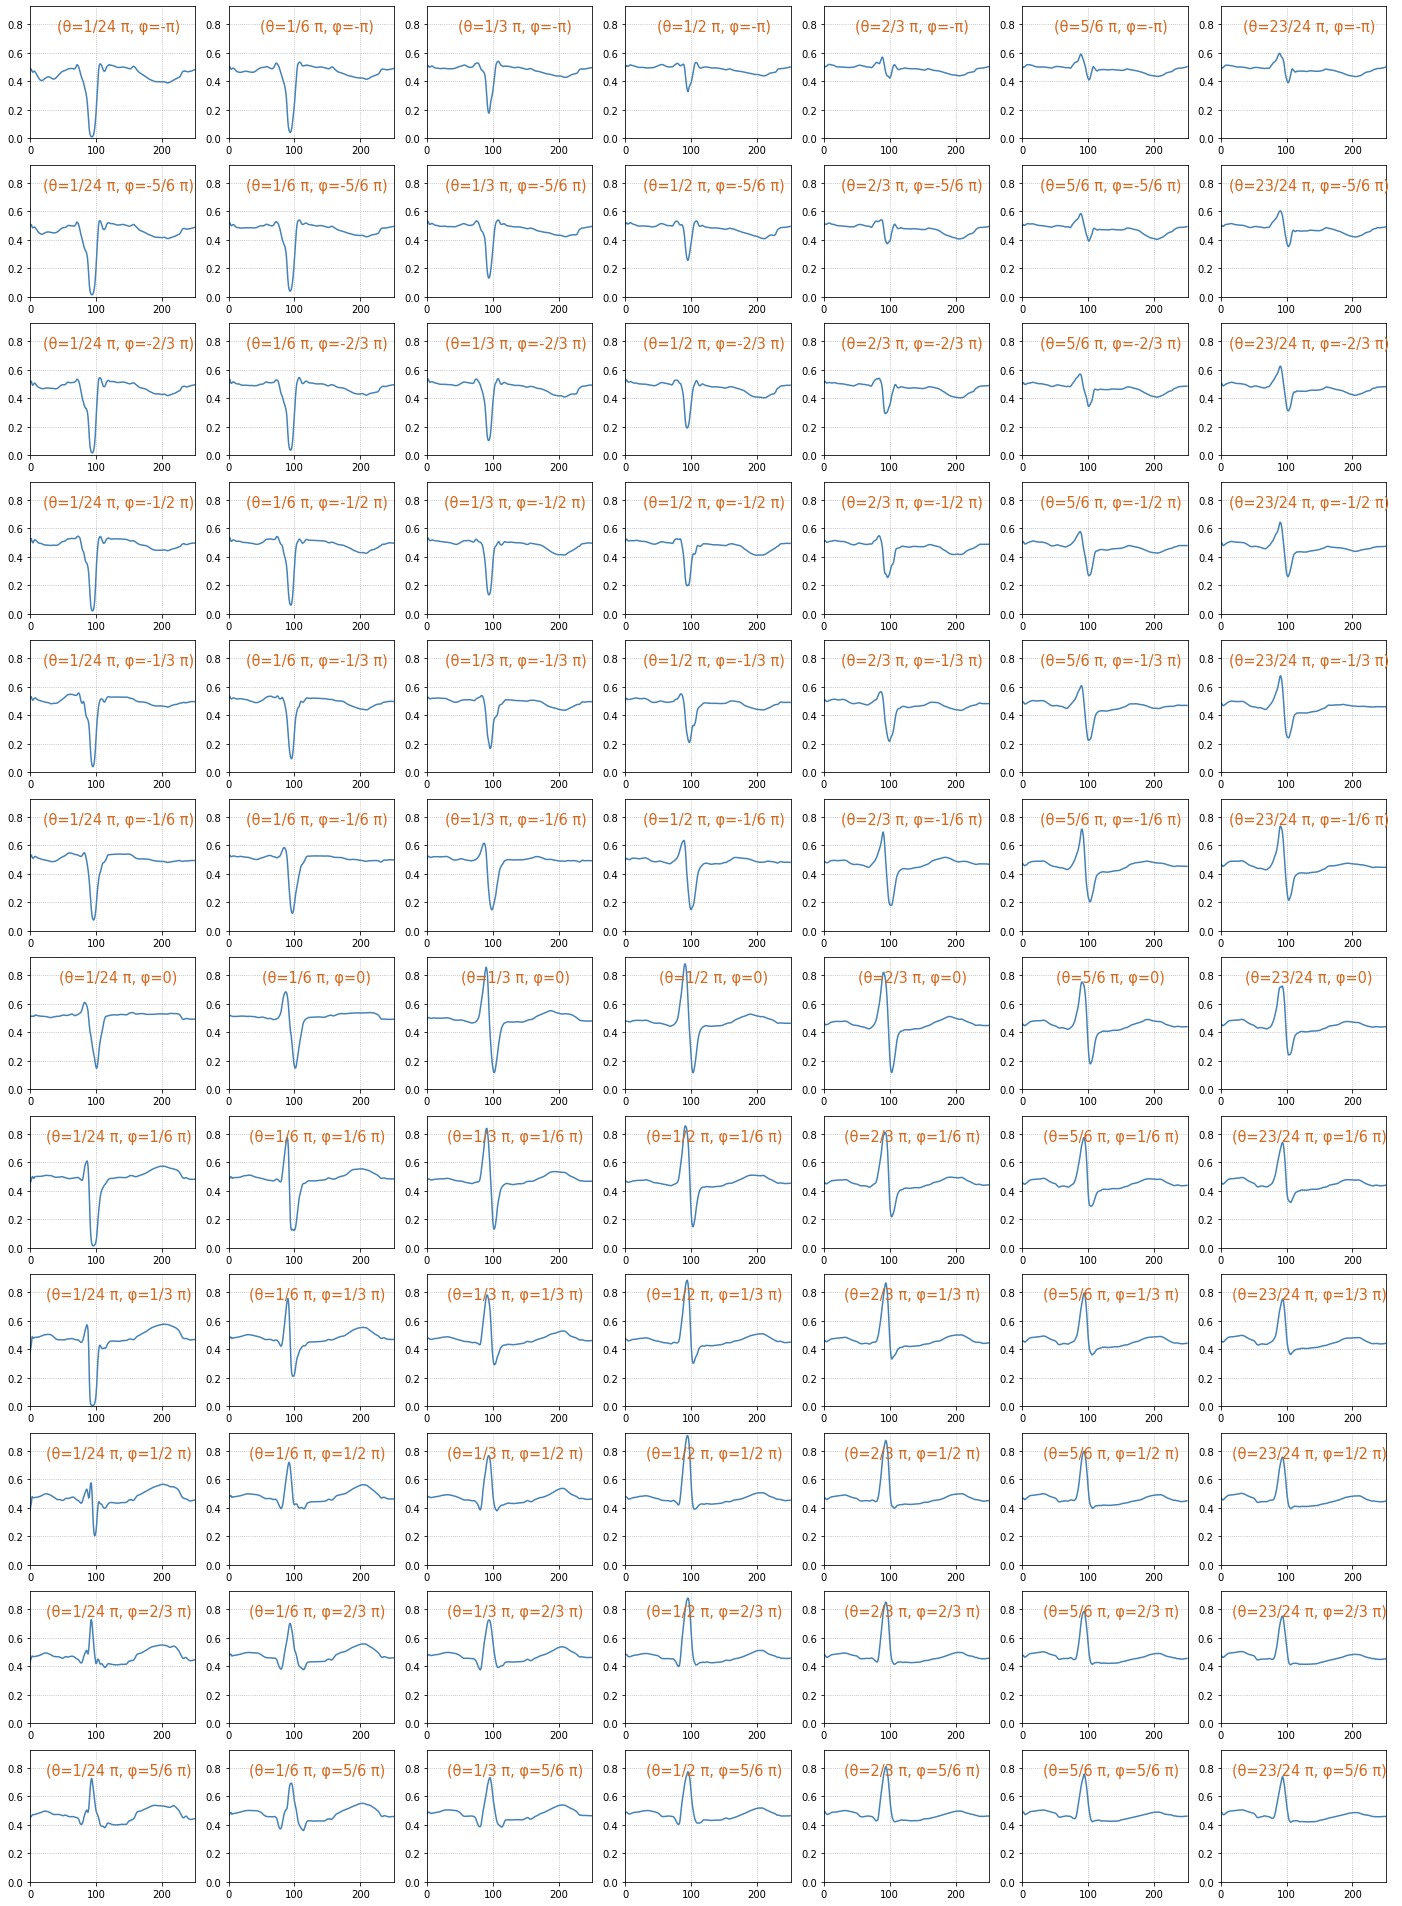

In [6]:
# plot
x = np.load(os.path.join(gener.latent_save_dir, 'all_theta_data.npz'))
i = 0
data = x['all_theta_data'][i]
rois = x['rois'][i]
case_idx = i

max_, min_ = np.max(data), np.min(data)
end_points = rois[-1, 0]-20
data = data[:, :end_points]
theta = ['1/24 π', '1/6 π', '1/3 π', '1/2 π', '2/3 π', '5/6 π', '23/24 π', ]
phi = ['-π', '-5/6 π', '-2/3 π', '-1/2 π', '-1/3 π', '-1/6 π', '0', '1/6 π', '1/3 π', '1/2 π', '2/3 π', '5/6 π', ]
plt.figure(figsize=(3*8.1, 3*11.5))
for i in range(12):
    for j in range(7):
        ax = plt.subplot(12, 7, j+1+i*7)
        plt.axis([0.0, end_points, 0.0, max_+0.02])
        plt.plot(data[7*i+j], label='(θ={}, φ={})'.format(theta[j], phi[i]), color='steelblue')
        leg = ax.legend(fontsize=14.5, handlelength=0.0, handleheight=0.0, frameon=False, loc='upper center', )
        for text in leg.get_texts():
            plt.setp(text, color='chocolate')
        plt.grid(linestyle=':')


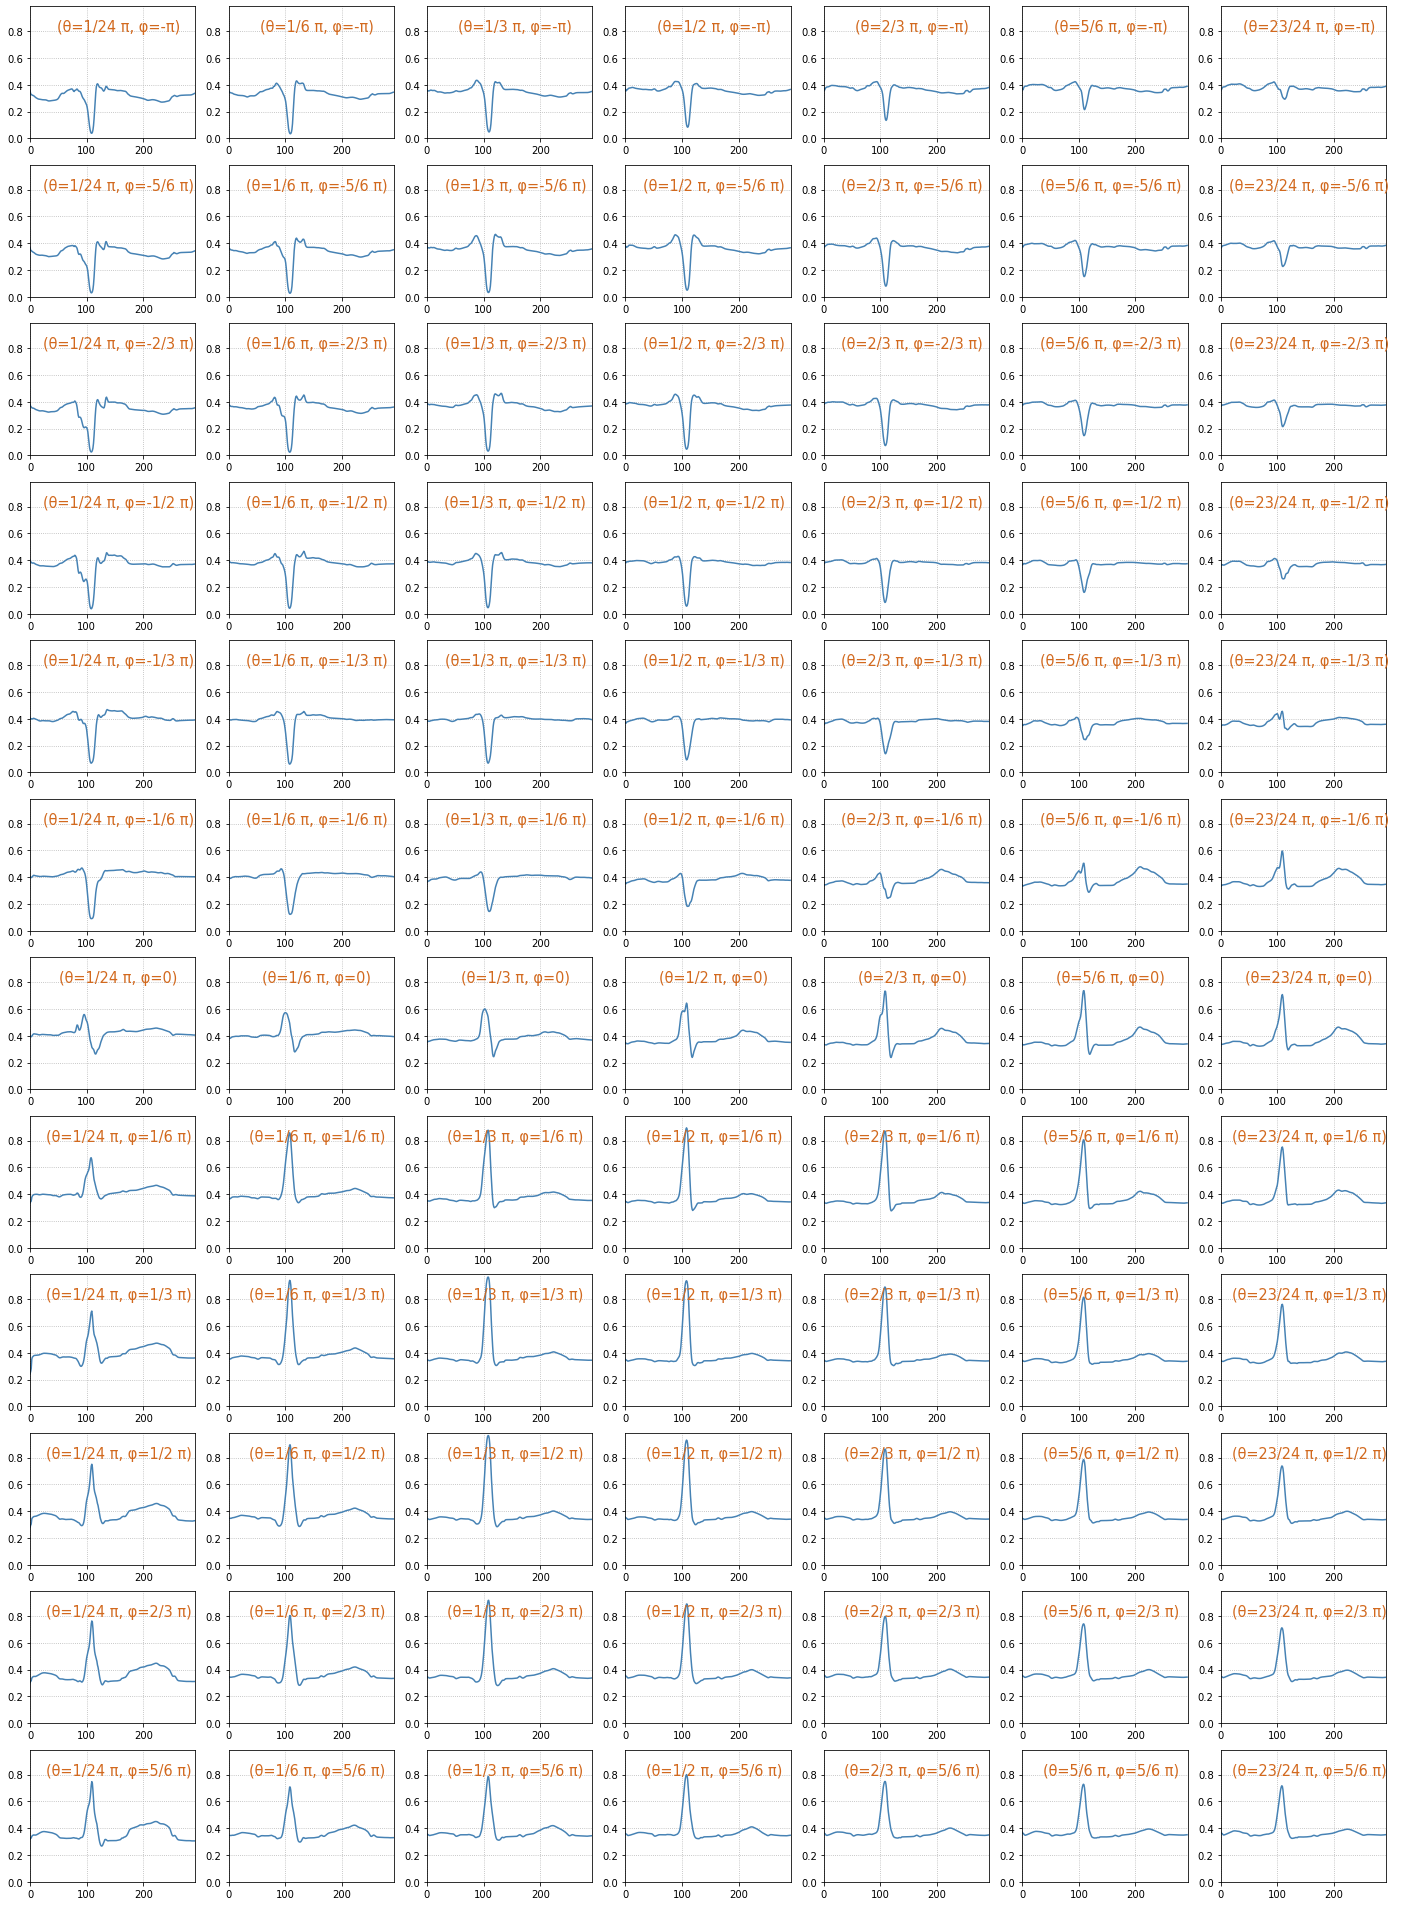

In [7]:
i = 1
data = x['all_theta_data'][i]
rois = x['rois'][i]
case_idx = i

max_, min_ = np.max(data), np.min(data)
end_points = rois[-1, 0]-20
data = data[:, :end_points]
theta = ['1/24 π', '1/6 π', '1/3 π', '1/2 π', '2/3 π', '5/6 π', '23/24 π', ]
phi = ['-π', '-5/6 π', '-2/3 π', '-1/2 π', '-1/3 π', '-1/6 π', '0', '1/6 π', '1/3 π', '1/2 π', '2/3 π', '5/6 π', ]
plt.figure(figsize=(3*8.1, 3*11.5))
for i in range(12):
    for j in range(7):
        ax = plt.subplot(12, 7, j+1+i*7)
        plt.axis([0.0, end_points, 0.0, max_+0.02])
        plt.plot(data[7*i+j], label='(θ={}, φ={})'.format(theta[j], phi[i]), color='steelblue')
        leg = ax.legend(fontsize=14.5, handlelength=0.0, handleheight=0.0, frameon=False, loc='upper center', )
        for text in leg.get_texts():
            plt.setp(text, color='chocolate')
        plt.grid(linestyle=':')
